In [20]:
import numpy as np
from PIL import Image
import cv2 #opencv
import io
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (30, 30)
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import clear_output
from random import randint
import os
import mss
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
#keras imports
%matplotlib inline 
from keras.models import model_from_json
from ast import literal_eval
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle
from io import BytesIO
import base64
import json

In [21]:
#path variables
game_url = "file:///home/paperspace/Chrome-Dino-Reinforcement-Learning/game/dino.html"
chrome_driver_path = "../chromedriver"
loss_file_path = "./objects/loss_df.csv"
actions_file_path = "./objects/actions_df.csv"
q_value_file_path = "./objects/q_values.csv"
scores_file_path = "./objects/scores_df.csv"

In [22]:
'''
* Game class: Selenium interfacing between the python and browser
* __init__():  Launch the broswer window using the attributes in chrome_options
* get_crashed() : return true if the agent as crashed on an obstacles. Gets javascript variable from game decribing the state
* get_playing(): true if game in progress, false is crashed or paused
* restart() : sends a signal to browser-javascript to restart the game
* press_up(): sends a single to press up get to the browser
* get_score(): gets current game score from javascript variables.
* pause(): pause the game
* resume(): resume a paused game if not crashed
* end(): close the browser and end the game
'''
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        #chrome_options.add_argument('--headless')
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.get('chrome://dino')
        self._driver.execute_script("Runner.config.ACCELERATION=0")
        self._driver.execute_script(init_script)
        #modifying game before trainNetworkining
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        self._driver.execute_script("Runner.instance_.restart()")
        
        time.sleep(0.25)# no actions are possible 
                        # for 0.25 sec after game starts, 
                        # skip learning at this time and make the model wait
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array) # the javascript object is of type array with score in the formate[1,0,0] which is 100.
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

In [23]:
class DinoAgent:
    def __init__(self,game): #takes game as input for taking actions
        self._game = game; 
        self.jump(); #to start the game, we need to jump once
        time.sleep(1) # no action can be performed for the first time when game starts
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [24]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img() #display the processed image on screen using openCV, implemented using python coroutine 
        self._display.__next__() # initiliaze the display coroutine 
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1] # storing actions in a dataframe
        score = self._game.get_score() 
        reward = 0.1
        is_over = False #game over
        if actions[1] == 1:
            self._agent.jump()
        image = grab_screen(self._game._driver) 
        #self._display.send(image) #display the image on screen
        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = score # log the score when game is over
            self._game.restart()
            reward = -1
            is_over = True
        return image, reward, is_over #return the Experience tuple

In [25]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
sct = mss.mss()
monitor = {'top': 120, 'left': 100, 'width': 500, 'height': 400}
def grab_screen(_driver = None):
    if(_driver==None):
        screen = np.array(sct.grab(monitor)) 
    else:
        
        image_b64 = _driver.execute_script(getbase64Script)
        screen = np.array(Image.open(BytesIO(base64.b64decode(image_b64))))
    image = process_img(screen)#processing image as required
    return image

def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[:300, :500]
#     image = cv2.Canny(image, threshold1 = 80, threshold2 = 255) #apply the canny edge detection
    image = cv2.resize(image, (80,80))
#     image = cv2.GaussianBlur(image,(5,5),0)
#     cv2.dilate(image,(11,11))
    
     # resale image dimensions

    return  image
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

(80, 80)

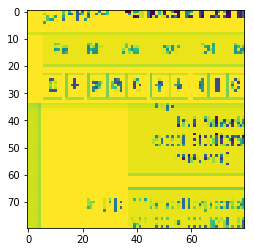

In [26]:
plt.imshow(grab_screen())
grab_screen().shape

In [27]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])
q_values_df =pd.read_csv(actions_file_path) if os.path.isfile(q_value_file_path) else pd.DataFrame(columns = ['qvalues'])

In [28]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

In [29]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 100. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 16 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 80,80
img_channels = 4 #We stack 4 frames

In [30]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
#     Conv2D(32, (8, 8), strides=(4, 4), input_shape=(20, 40, 4..., padding="same")`
    model.add(Conv2D(32, (8, 8), padding='same',strides=(4, 4),input_shape=(img_cols,img_rows,img_channels)))  #80*80*4
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4),strides=(2, 2),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),strides=(1, 1),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [31]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,game_state,observe=False):
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #load from file system
    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = game_state.get_state(do_nothing) # get next step after performing the action
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2) # stack 4 images to create placeholder input
    

    
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    
    initial_state = s_t 

    if observe :
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time") # resume from the previous time step stored in file system
    while (True): #endless running
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 #reward at 4
        a_t = np.zeros([ACTIONS]) # action at t
        
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0: #parameter to skip frames for actions
            if  random.random() <= epsilon: #randomly explore an action
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[0] = 1
            else: # predict the output
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)         # chosing index with maximum q value
                action_index = max_Q 
                a_t[action_index] = 1        # o=> do nothing, 1=> jump
                
        #We reduced the epsilon (exploration parameter) gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('fps: {0}'.format(1 / (time.time()-last_time))) # helpful for measuring frame rate
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x20x40x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one
        
        
        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
            q_values_df.loc[len(q_values_df)] = np.max(Q_sa)
        else:
            # artificial time delay as training done with this delay
            time.sleep(0.12)
        s_t = initial_state if terminal else s_t1 #reset game to initial frame if terminate
        t = t + 1
        
        # save progress every 1000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            game_state._game.pause()
            model.save_weights("model_final.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            q_values_df.to_csv(q_value_file_path,index=False)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)
            clear_output()
            game_state._game.resume()
        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


In [32]:

def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)    
    model = buildmodel()
    try:
        trainNetwork(model,game_state,observe=observe)
    except StopIteration:
        game.end()

In [ ]:
'''tensorflowjsScript = " \
var scc = document.createElement('script'); \
scc.src = 'https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.10.0'; \
document.head.appexndChild(scc); "

getTensorScript = "canvasRunner = document.getElementsByClassName('runner-canvas')[0]; \
img_data = tf.fromPixels(canvasRunner); \
return img_data.dataSync().toString()"
'''
init_script = "document.getElementsByClassName('runner-canvas')[0].id = 'runner-canvas'"

getbase64Script = "canvasRunner = document.getElementById('runner-canvas'); \
return canvasRunner.toDataURL().substring(22)"

In [ ]:
playGame(observe=False);

TIMESTEP 561000 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.86888 / Loss  0.0191952623427
fps: 0.15386049979981978
TIMESTEP 561001 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.74414 / Loss  0.0157411713153
fps: 3.999965668019283
TIMESTEP 561002 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.85386 / Loss  3.21446800232
fps: 4.287597841431713
TIMESTEP 561003 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.9406 / Loss  0.0137970075011
fps: 4.004563764284439
TIMESTEP 561004 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  10.2901 / Loss  0.0276555325836
fps: 3.9954618501057855
TIMESTEP 561005 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.85912 / Loss  0.0122736189514
fps: 3.7302530589593403
TIMESTEP 561006 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.80

TIMESTEP 561055 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.88705 / Loss  0.00429341942072
fps: 4.293241756273319
TIMESTEP 561056 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  10.0147 / Loss  0.00506884930655
fps: 4.2794784597851026
TIMESTEP 561057 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.9834 / Loss  0.00217481749132
fps: 3.9898558086530027
TIMESTEP 561058 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.91204 / Loss  0.0137391360477
fps: 3.752986557694183
TIMESTEP 561059 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.82368 / Loss  0.00862845033407
fps: 4.002874531290113
TIMESTEP 561060 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  10.124 / Loss  0.0074420478195
fps: 4.004995855884072
TIMESTEP 561061 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  1

TIMESTEP 561110 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.54786 / Loss  0.00214180443436
fps: 4.039194877508785
TIMESTEP 561111 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.71255 / Loss  0.00905165448785
fps: 4.012010288520495
TIMESTEP 561112 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.56598 / Loss  0.212710022926
fps: 4.0032756905961335
TIMESTEP 561113 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.59857 / Loss  0.00800973549485
fps: 3.9971067390299573
TIMESTEP 561114 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.60051 / Loss  0.00690496712923
fps: 3.7381289142119707
TIMESTEP 561115 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.85028 / Loss  0.00804615672678
fps: 3.7469918588788964
TIMESTEP 561116 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MA

TIMESTEP 561165 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.73682 / Loss  0.0033229899127
fps: 4.2936680663924545
TIMESTEP 561166 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.68246 / Loss  0.00941754039377
fps: 4.290417942753566
TIMESTEP 561167 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.72949 / Loss  0.00746081210673
fps: 3.971965298486615
TIMESTEP 561168 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.71778 / Loss  0.0048078559339
fps: 4.308213155840421
TIMESTEP 561169 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.79099 / Loss  0.00669001787901
fps: 4.627564338782887
TIMESTEP 561170 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.76785 / Loss  0.00421955995262
fps: 4.591827708368913
TIMESTEP 561171 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  

fps: 4.286642567547542
TIMESTEP 561220 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.90105 / Loss  0.0134141063318
fps: 4.288290462056901
TIMESTEP 561221 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.88179 / Loss  0.00934125483036
fps: 3.97334621687934
TIMESTEP 561222 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.89822 / Loss  0.497902929783
fps: 3.9965164032053666
TIMESTEP 561223 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  1.20034 / Loss  0.0814164876938
fps: 4.295026670448692
TIMESTEP 561224 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.96797 / Loss  0.0051408233121
fps: 3.997499123168184
TIMESTEP 561225 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.82708 / Loss  0.00385220721364
fps: 4.27510781276915
TIMESTEP 561226 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / RE

fps: 4.613475122698104
TIMESTEP 561275 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.83861 / Loss  0.00720400968567
fps: 4.294358252935136
TIMESTEP 561276 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.80443 / Loss  0.00936695467681
fps: 4.2464762066752115
TIMESTEP 561277 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.77757 / Loss  0.00678228586912
fps: 4.648391411849325
TIMESTEP 561278 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.87023 / Loss  0.0268393196166
fps: 4.626068887474673
TIMESTEP 561279 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.80157 / Loss  0.00800571963191
fps: 4.617639999911925
TIMESTEP 561280 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.90238 / Loss  0.00505276862532
fps: 4.611304242664116
TIMESTEP 561281 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 

fps: 4.274798454905878
TIMESTEP 561330 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.77135 / Loss  0.00624181935564
fps: 4.011806903939779
TIMESTEP 561331 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.68295 / Loss  0.0780912786722
fps: 4.298134023608306
TIMESTEP 561332 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.67784 / Loss  0.418139725924
fps: 3.9518203060224617
TIMESTEP 561333 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.76016 / Loss  0.00396644324064
fps: 4.3471137422682125
TIMESTEP 561334 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.88485 / Loss  0.00559284770861
fps: 4.282292259046631
TIMESTEP 561335 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.67435 / Loss  0.0261537283659
fps: 4.292793562709238
TIMESTEP 561336 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 

fps: 3.7691614358439787
TIMESTEP 561385 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.89743 / Loss  0.00461096502841
fps: 4.000255601048727
TIMESTEP 561386 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.89495 / Loss  0.0360445789993
fps: 4.615846149613448
TIMESTEP 561387 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.89775 / Loss  0.711641907692
fps: 4.579604439950822
TIMESTEP 561388 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.88041 / Loss  2.08917164803
fps: 3.7732744862727174
TIMESTEP 561389 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  10.0771 / Loss  0.00433453638107
fps: 4.272438352592206
TIMESTEP 561390 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  10.0616 / Loss  0.632640421391
fps: 4.0085670459269735
TIMESTEP 561391 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / R

fps: 4.594730136681671
TIMESTEP 561440 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.27909 / Loss  0.0158459655941
fps: 4.303823393904692
TIMESTEP 561441 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  8.79412 / Loss  0.0153800407425
fps: 4.2659332858019
TIMESTEP 561442 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.43437 / Loss  0.00750101730227
fps: 3.5118909165504912
TIMESTEP 561443 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.42678 / Loss  0.0205725934356
fps: 4.295426941046108
TIMESTEP 561444 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.26704 / Loss  0.0498953014612
fps: 4.290799796626329
TIMESTEP 561445 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.3019 / Loss  0.0168265327811
fps: 4.278993846204071
TIMESTEP 561446 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REW

fps: 4.585236695414331
TIMESTEP 561495 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.99277 / Loss  0.00343864038587
fps: 4.007150056606207
TIMESTEP 561496 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.94333 / Loss  0.00304957618937
fps: 3.9839135266572314
TIMESTEP 561497 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.93618 / Loss  0.00203560711816


In [ ]:
()